# Experiment 1: HANK with different borrowing constraints
How much agents can smooth their consumption after a shock occurs depends on how much they are allowed to borrow.

In this notebook, we differentiate between a HANK model with
- One household type which cannot borrow
- One household type which can borrow
- Two household types where one can borrow and one cannot

### Assumptions:
- same discount factor (for comparison)


### Insights:
- Need to add unemployment probability 


### Changes made:
- dist_grid: make sure it can handle negative numbers
- Steady state seems to work now (with unemployment probability)
- Jacobians are still off! (even with a minimal negative number as borrowing constraint the solution is off!)


In [1]:
from ConsIndShockModel_HANK_Borrowing import IndShockConsumerType 
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import optimize

In [2]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [3]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss
C_ss = Y_ss - G_ss

print('Z_ss: ' +str(Z_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Z_ss: 0.7925
C_ss: 0.8


In [4]:
HANK_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0001,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,                   # Allowing for borrowing (Will use natural borrowing constraint)
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

In [5]:
# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function]

In [6]:
### Target Steady State Asset
def ss_func(beta):
    HANK_Dict['DiscFac'] = beta
    Agent_func = IndShockConsumerType(**HANK_Dict, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [7]:
np.max([-1.0, 0.0])

0.0

In [8]:
# Create a new agent
HANK_Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**HANK_Dict, verbose = False)

In [9]:
A_ss, C_ss = Agent_GE.compute_steady_state()
MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

Our general equilibrium agent has a discount rate of: 0.96. Where the steady state MPC is 0.29 and Bond Holdings are 0.25


In [10]:
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 8.076706886291504


### Allow for borrowing

In [25]:
HANK_Borrowing_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0001,                     # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": -0.000000001,                   # Allowing for borrowing (Will use natural borrowing constraint)
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

HANK_Borrowing_Dict['TranShkMean_Func'] = [function]

In [12]:
# ### Target Steady State Asset
# def ss_func(beta):
#     HANK_Borrowing_Dict['DiscFac'] = beta
#     Agent_func = IndShockConsumerType(**HANK_Borrowing_Dict, verbose = False)
#     Agent_func.solve()
#     HANK_Borrowing_Dict['mMin'] = Agent_func.solution[0].mNrmMin
#     Agent_func = IndShockConsumerType(**HANK_Borrowing_Dict, verbose = False)
#     A_ss = Agent_func.compute_steady_state()[0]
#     return A_ss
    

# def ss_dif(beta):    
#     return ss_func(beta) - Asset_target 

# Asset_target = B_ss
# DiscFac = optimize.brentq(ss_dif,.75,.99)

In [13]:
# stop

In [26]:
# Create a new agent
HANK_Borrowing_Dict['DiscFac'] = HANK_Dict['DiscFac']
Agent_GE_Borrowing = IndShockConsumerType(**HANK_Borrowing_Dict, verbose = False)

In [27]:
Agent_GE_Borrowing.solve()

In [28]:
Agent_GE_Borrowing.solution[0].mNrmMin


0.0

In [29]:
HANK_Borrowing_Dict['mMin'] = Agent_GE_Borrowing.solution[0].mNrmMin
Agent_GE_Borrowing.mMin = HANK_Borrowing_Dict['mMin']

Agent_GE_Borrowing.define_distribution_grid()

dist_mGrid = Agent_GE_Borrowing.dist_mGrid

Agent_GE_Borrowing.compute_steady_state()

(0.2500001100573304, 0.7934375025931769)

In [30]:
# ## 'cheating' using SS values from the model without borrowing
# A_ss, C_ss = Agent_GE.compute_steady_state()

In [31]:
# Agent_GE_Borrowing.A_ss = A_ss
# Agent_GE_Borrowing.C_ss = C_ss

In [32]:
Agent_GE_Borrowing.calc_jacobian('labor',T)

(array([[ 2.35261430e-01,  2.97728028e-01,  2.45726070e-01, ...,
          1.19591566e-01,  1.19591566e-01,  1.19591566e-01],
        [ 1.64280745e-01,  1.79720138e-01,  2.23879458e-01, ...,
          8.02120286e-02,  8.02120286e-02,  8.02120286e-02],
        [ 1.22247331e-01,  1.28792947e-01,  1.34059047e-01, ...,
          5.93138254e-02,  5.93138254e-02,  5.93138254e-02],
        ...,
        [ 1.30007116e-09, -4.86555241e-14, -1.56000213e-13, ...,
          4.40971640e-02,  1.03752548e-01,  7.41378913e-02],
        [ 1.30118138e-09, -4.87665464e-14, -1.55972457e-13, ...,
          2.76857172e-02,  4.40971640e-02,  1.03752548e-01],
        [ 1.30229161e-09, -4.87665464e-14, -1.56055724e-13, ...,
          2.03563855e-02,  2.76857172e-02,  4.40971640e-02]]),
 array([[ 6.47352363e-01,  1.28485162e-01,  1.80487120e-01, ...,
          3.06621624e-01,  3.06621624e-01,  3.06621624e-01],
        [ 4.98324858e-01,  5.20563883e-01, -3.78841759e-02, ...,
          2.34886945e-01,  2.34886945e

In [21]:
# stop

In [33]:
A_ss, C_ss = Agent_GE_Borrowing.compute_steady_state()
MPC = Agent_GE_Borrowing.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE_Borrowing.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

Our general equilibrium agent has a discount rate of: 0.96. Where the steady state MPC is 8.00 and Bond Holdings are 0.22


In [34]:
start = time.time()

CJACR_Borrowing, AJACR_Borrowing = Agent_GE_Borrowing.calc_jacobian('Rfree',T)
CJACZ_Borrowing, AJACZ_Borrowing = Agent_GE_Borrowing.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 8.76419472694397


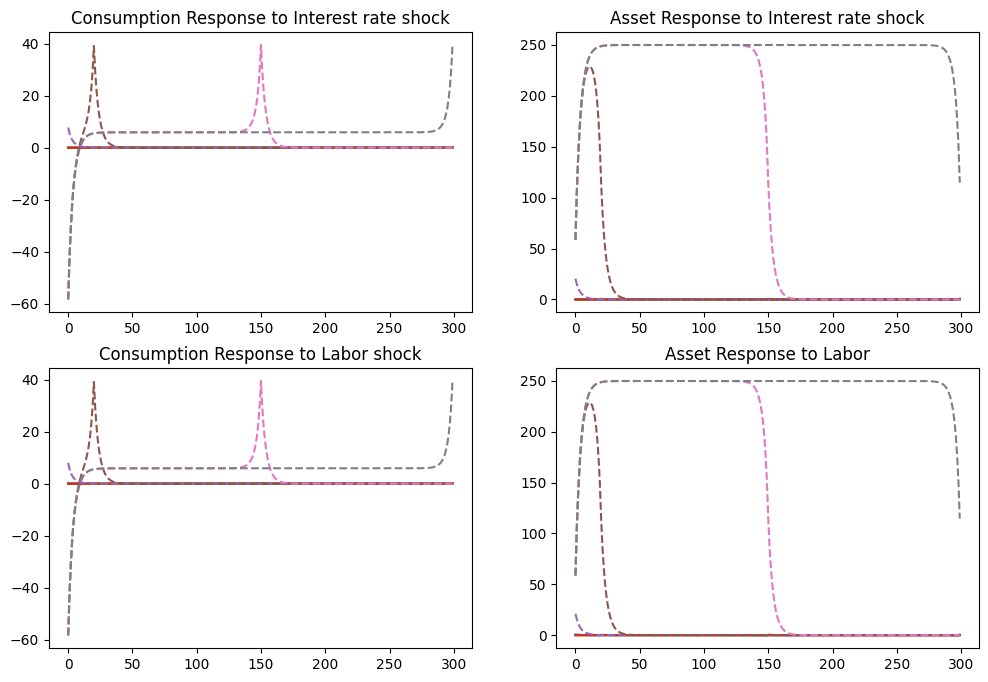

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].plot(CJACR_Borrowing.T[0], '--')
axs[0, 0].plot(CJACR_Borrowing.T[20], '--')
axs[0, 0].plot(CJACR_Borrowing.T[150], '--')
axs[0, 0].plot(CJACR_Borrowing.T[-1], '--')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].plot(AJACR_Borrowing.T[0], '--')
axs[0, 1].plot(AJACR_Borrowing.T[20], '--')
axs[0, 1].plot(AJACR_Borrowing.T[150], '--')
axs[0, 1].plot(AJACR_Borrowing.T[-1], '--')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].plot(CJACZ_Borrowing.T[0], '--')
axs[1, 0].plot(CJACZ_Borrowing.T[20], '--')
axs[1, 0].plot(CJACZ_Borrowing.T[150], '--')
axs[1, 0].plot(CJACZ_Borrowing.T[-1], '--')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].plot(AJACZ_Borrowing.T[0], '--')
axs[1, 1].plot(AJACZ_Borrowing.T[20], '--')
axs[1, 1].plot(AJACZ_Borrowing.T[150], '--')
axs[1, 1].plot(AJACZ_Borrowing.T[-1], '--')
axs[1, 1].set_title("Asset Response to Labor")

plt.show()